In [1]:
import os, sys
import glob
from typing import *

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from scipy import stats

import torch

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), "tcr")
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
import data_loader as dl
import featurization as ft
import canonical_models as models
import model_utils
import utils

DEVICE = utils.get_device(3)
TRAINED_MODEL_DIR = "/home/wukevin/projects/tcr/tcr_models"

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/pird_antigen_cv")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
assert os.path.isdir(PLOT_DIR)

In [2]:
pird_data = dl.load_pird(with_antigen_only=True)
pird_data = pird_data.loc[~pd.isnull(pird_data['CDR3.beta.aa'])]
pird_data.head()

INFO:root:PIRD data 0.1655 data labelled with antigen sequence
INFO:root:PIRD: Removing 95 entires with non amino acid residues
INFO:root:Entries with antigen sequence: 8429/51044
INFO:root:Unique antigen sequences: 73
INFO:root:PIRD data TRA/TRB instances: Counter({'TRB': 46428, 'TRA': 4011, 'TRA-TRB': 605})
INFO:root:PIRD entries with TRB sequence: 4607
INFO:root:PIRD entries with TRB sequence: 47040
INFO:root:PIRD entries with TRA and TRB:  605


,ICDname,Disease.name,Category,Antigen,Antigen.sequence,HLA,Locus,CDR3.alpha.aa,CDR3.beta.aa,CDR3.alpha.nt,...,Cell.subtype,Prepare.method,Evaluate.method,Case.num,Control.type,Control.num,Filteration,Journal,Pubmed.id,Grade
0,A15,Tuberculosis,Pathogen,CFP10,TAAQAAVVRFQEAAN,DRB1*15:03,TRA-TRB,CIEHTNSGGSNYKLTF,CASSLEETQYF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5
1,A15,Tuberculosis,Pathogen,CFP10,TAAQAAVVRFQEAAN,DRB1*15:03,TRA-TRB,CIVHTNSGGSNYKLTF,CASSPEETQYF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5
2,A15,Tuberculosis,Pathogen,CFP10,TAAQAAVVRFQEAAN,DRB1*15:03,TRA-TRB,CIVKTNSGGSNYKLTF,CASSFEETQYF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5
1845,A15,Tuberculosis,Pathogen,Rv1195,ADTLQSIGATTVASN,DRB1*15:03,TRA-TRB,CAGAGGGGFKTIF,CASSVALASGANVLTF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5
1846,A15,Tuberculosis,Pathogen,Rv1195,ADTLQSIGATTVASN,DRB1*15:03,TRA-TRB,CAGPTGGSYIPTF,CASSVALATGEQYF,NaN,...,CD4,Multiple PCR,Antigen-specific ex vivo proliferation,22.0,NaN,NaN,NaN,Nature,28636589,5


In [3]:
tcrdb_data = dl.load_tcrdb()
tcrdb_data = tcrdb_data.loc[tcrdb_data['tra_trb'] == 'TRB']
tcrdb_data.head()

INFO:root:Dropping 4 TCRdb entries for unknown TRA TRB status
INFO:root:TCRdb: Removing 0 entries with non-amino acid residues


,accession,RunId,AASeq,cloneFraction,tra_trb
0,PRJNA330606,SRR4102112,CANTGTGFNEQFF,0.008305,TRB
1,PRJNA330606,SRR4102112,CASSHTRGVGTQYF,0.003841,TRB
2,PRJNA330606,SRR4102112,CSGVHEQYF,0.003824,TRB
3,PRJNA330606,SRR4102112,CASSLPNGEGSSYEQYF,0.002825,TRB
4,PRJNA330606,SRR4102112,CASSQGGIAGDVYEQYF,0.002614,TRB


In [4]:
ESM_DEVICE = utils.get_device(0)
esm_model, esm_alphabet = torch.hub.load("facebookresearch/esm", "esm1b_t33_650M_UR50S")
esm_model = esm_model.to(ESM_DEVICE)
esm_batch_converter = esm_alphabet.get_batch_converter()

Using cache found in /home/wukevin/.cache/torch/hub/facebookresearch_esm_master


In [5]:
tcrdb_neg_rng = np.random.default_rng(seed=64)

def get_perf_comparison(model_dirname:str, min_positive:int=20):
    """
    Given the directory of a model *that has been trained without a specific antigen*,
    evaluate the performance of that model for generalizing to that excluded antigen
    """
    assert os.path.isdir(model_dirname)

    # Determine the antigen sequence that was hidden from the model's second pretraining step
    held_out_seq = os.path.basename(model_dirname).split("_")[-1]
    print(held_out_seq)
    
    # Subset to sequences with the held out sequence
    pird_pos_table = pird_data.loc[pird_data['Antigen.sequence'] == held_out_seq]
    pird_pos_trbs = list(pird_pos_table['CDR3.beta.aa'])
    if len(pird_pos_trbs) < min_positive:  # If we do not have enough positive examples, return None
        return None
    
    # Get a negative set of sequences from TCRdb, sampled at 5 negatives per positive sequence
    tcrdb_trbs = tcrdb_data['AASeq']
    rand_neg_trbs = list(tcrdb_data.iloc[tcrdb_neg_rng.choice(
        np.arange(len(tcrdb_trbs)), size=int(len(pird_pos_trbs) * 5), replace=False
    )]['AASeq'])

    # Combine positive and negative sequences
    combined_trbs = pird_pos_trbs + rand_neg_trbs
    combined_labels = np.array([1] * len(pird_pos_trbs) + [0] * len(rand_neg_trbs))

    # Find random indices for training and testing sets at 70/30 split
    train_idx, _, test_idx = dl.shuffle_indices_train_valid_test(
        np.arange(len(combined_trbs)), valid=0.0, test=0.3,
    )

    # Create various embeddings to evaluate
    # K-mer featurization
    combined_kmer_ft = np.array([ft.kmer_ft(aa) for aa in combined_trbs])
    # TCR-BERT embedding (without the held-out antigen)
    cls_embedding = model_utils.get_transformer_embeddings(
        model_dirname,
        combined_trbs,
        method='mean',
        layers=[-5],
        device=3,
    )
    # TCR-BERT embedding (without held-ont antigen and without MLM pre-training)
    cls_no_mlm_embedding = model_utils.get_transformer_embeddings(
        os.path.join("/home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm", os.path.basename(model_dirname)),
        combined_trbs,
        method='mean',
        layers=[-5],  # Unsure if this is best here w/o sweep
        device=3,
    )
    # TCR-BERT embedding (with only MLM pre-training)
    mlm_embedding = model_utils.get_transformer_embeddings(
        "wukevin/tcr-bert-mlm-only",
        combined_trbs,
        method='mean',
        layers=[-5],  # NOTE we use a different layer
        device=3,
    )
    # External: ESM embed
    esm_embedding = model_utils.get_esm_embedding(
        esm_model, esm_batch_converter, combined_trbs, ESM_DEVICE
    )
    # External: TAPE embed
    tape_embedding = model_utils.get_tape_embedding(combined_trbs, device=2)

    ## Perform evaluation
    eval_preds = {}  # Contains each method's predictions, which we summarize at the end
    # For each embedding, train a PCA-SVM classifier on top of embedding
    embeds_named = {
        "MLM": mlm_embedding,
        "MLM + CLS": cls_embedding,
        "ESM": esm_embedding,
        "TAPE": tape_embedding,
        "CLS": cls_no_mlm_embedding,
    }
    for embed_name, embed in embeds_named.items():
        pcasvm = models.ModelOnPCA(SVC, probability=True, kernel='rbf')
        pcasvm.fit(embed[train_idx], combined_labels[train_idx])
        eval_preds[embed_name] = pcasvm.predict_proba(embed[test_idx])
    
    # SETE requires a separate GBC classifier, so this is handled outside of loop
    pca_gbc = models.ModelOnPCA(
        GradientBoostingClassifier, n_components=0.9,
        learning_rate=0.1, max_features='sqrt',
        n_estimators=70, max_depth=10, loss='deviance',
        random_state=99,
    )
    pca_gbc.fit(combined_kmer_ft[train_idx], combined_labels[train_idx])
    eval_preds['SETE'] = pca_gbc.predict_proba(combined_kmer_ft[test_idx])

    # Additional baseline: LR and PCA-SVM on k-mer featurization
    lr = LogisticRegression()
    lr.fit(combined_kmer_ft[train_idx], combined_labels[train_idx])
    eval_preds['Logistic on k-mers'] = lr.predict_proba(combined_kmer_ft[test_idx])
    # PCA-SVM
    pcasvm = models.ModelOnPCA(SVC, probability=True, kernel='rbf')
    pcasvm.fit(combined_kmer_ft[train_idx], combined_labels[train_idx])
    eval_preds['PCA-SVM on k-mers'] = pcasvm.predict_proba(combined_kmer_ft[test_idx])
    
    # Compute metrics
    retval = pd.Series(
        {
            k: metrics.average_precision_score(combined_labels[test_idx], v[:, 1])
            for k, v in eval_preds.items()
        },
        name=held_out_seq,
    )
    return retval


excl_models = [d for d in glob.glob(
    "/home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_*"
) if os.path.isdir(d)]

get_perf_comparison(excl_models[0])

FPRPWLHGL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_FPRPWLHGL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_FPRPWLHGL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

MLM                   0.787702
MLM + CLS             0.954536
ESM                   0.689791
TAPE                  0.715063
CLS                   0.902180
SETE                  0.770739
Logistic on k-mers    0.788745
PCA-SVM on k-mers     0.688166
Name: FPRPWLHGL, dtype: float64

In [6]:
perf_pairs = [get_perf_comparison(m) for m in excl_models]

FPRPWLHGL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_FPRPWLHGL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_FPRPWLHGL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

QIKVRVDMV


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_QIKVRVDMV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_QIKVRVDMV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

EIYKRWII


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_EIYKRWII were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_EIYKRWII were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint o

NFIRMVISNPAAT
GLCTLVAML


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_GLCTLVAML were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_GLCTLVAML were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

PQPELPYPQPE
LLWNGPMAV


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_LLWNGPMAV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_LLWNGPMAV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

KRWIILGLNK


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_KRWIILGLNK were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_KRWIILGLNK were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

KRGIVEQSSTSISSL
TPGPGVRYPL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_TPGPGVRYPL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_TPGPGVRYPL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

TQGYFPDWQNY
RFPLTFGWCF


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RFPLTFGWCF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RFPLTFGWCF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

IIKDYGKQM


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_IIKDYGKQM were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_IIKDYGKQM were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

AVFDRKSDAK
RPHERNGFTVL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RPHERNGFTVL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RPHERNGFTVL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkp

EPLPQGQLTAY


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_EPLPQGQLTAY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_EPLPQGQLTAY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkp

QIKVRVKMV


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_QIKVRVKMV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_QIKVRVKMV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

NLVPMVATV


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_NLVPMVATV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_NLVPMVATV were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

VLEETSVML
FWIDLFETIG
HSKKKCDEL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_HSKKKCDEL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_HSKKKCDEL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

FPTKDVAL
VTEHDTLLY


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_VTEHDTLLY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_VTEHDTLLY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

TPRVTGGGAM


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_TPRVTGGGAM were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_TPRVTGGGAM were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

IVTDFSVIK
LPPIVAKEI


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_LPPIVAKEI were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_LPPIVAKEI were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

FLRGRAYGL
YVLDHLIVV
YLAMPFATPMEAELARRSLA
FLKEKGGL
TPQDLNTML


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_TPQDLNTML were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_TPQDLNTML were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

ENPVVHFFKNIVTPR
RPRGEVRFL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RPRGEVRFL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RPRGEVRFL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

HPVGEADYFEY


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_HPVGEADYFEY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_HPVGEADYFEY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkp

KRWIIMGLNK
RYPLTFGWCF


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RYPLTFGWCF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RYPLTFGWCF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

GILGFVFTL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_GILGFVFTL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_GILGFVFTL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

ELRRKMMYM
KAFSPEVIPMF


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_KAFSPEVIPMF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_KAFSPEVIPMF were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkp

HPKVSSEVHI


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_HPKVSSEVHI were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_HPKVSSEVHI were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoi

RAKFKQLL


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_RAKFKQLL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_RAKFKQLL were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint o

ATDALMTGY


Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv/bert_class_pird_excl_ATDALMTGY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /home/wukevin/projects/tcr/tcr_models/bert_class_pird_antigen_cv_no_mlm/bert_class_pird_excl_ATDALMTGY were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint

RYPLTFGW


In [7]:
perf_pairs_df = pd.DataFrame([p for p in perf_pairs if p is not None])
convnet_perf_df = pd.read_csv("antigen_cv_convnet_baseline.csv", index_col=0).loc[perf_pairs_df.index]
perf_pairs_df['ConvNet'] = convnet_perf_df
perf_pairs_df

,MLM,MLM + CLS,ESM,TAPE,CLS,SETE,Logistic on k-mers,PCA-SVM on k-mers,ConvNet
FPRPWLHGL,0.838845,0.970254,0.648904,0.744820,0.929169,0.807075,0.806858,0.737876,0.816859
QIKVRVDMV,0.745504,0.902184,0.442358,0.411203,0.780144,0.735362,0.679398,0.605466,0.661762
EIYKRWII,0.452013,0.709170,0.496865,0.407459,0.653093,0.457142,0.512487,0.464664,0.341290
GLCTLVAML,0.718177,0.891797,0.634375,0.688435,0.779890,0.689595,0.720602,0.704064,0.714656
LLWNGPMAV,0.745249,0.916664,0.627239,0.702720,0.796853,0.734823,0.691577,0.678926,0.714525
KRWIILGLNK,0.622358,0.774500,0.566672,0.579333,0.804857,0.408998,0.384443,0.451683,0.434463
TPGPGVRYPL,0.640187,0.843780,0.515427,0.587288,0.812349,0.560289,0.580723,0.601793,0.688123
RFPLTFGWCF,0.364389,0.598790,0.360379,0.452289,0.362198,0.355809,0.486756,0.484159,0.305985
IIKDYGKQM,0.853475,0.964646,0.813761,0.717084,0.811592,0.519112,0.734404,0.761228,0.716234
RPHERNGFTVL,0.661395,0.693807,0.558203,0.549660,0.568001,0.741529,0.717850,0.717337,0.659245


In [8]:
def num_positives(model_dirname:str, min_positive:int=20) -> int:
    """
    Given a model dir name, extract the held-out sequence, train a model to predict that
    sequence using the held-out-classifier as well as the MLM-only model. Return performance
    of those two models (MLM, CLS)
    """
    # Determine held out sequence, and get corresponding TRBs
    assert os.path.isdir(model_dirname)
    held_out_seq = os.path.basename(model_dirname).split("_")[-1]
    pird_pos_table = pird_data.loc[pird_data['Antigen.sequence'] == held_out_seq]
    pird_pos_trbs = list(pird_pos_table['CDR3.beta.aa'])
    if len(pird_pos_trbs) < min_positive:
        return -1
    return len(pird_pos_trbs)
num_positive_examples = [num_positives(m) for m in excl_models]
num_positive_examples = np.array([i for i in num_positive_examples if i > 0])
num_positive_examples

array([  88,   24,   36,  143,  231,   98,   42,   26,   36,   21,   37,
         28, 4115,   34,  201,   71,   44,   45,   57,   24,   68,  225,
        103,   53,   61,   57])

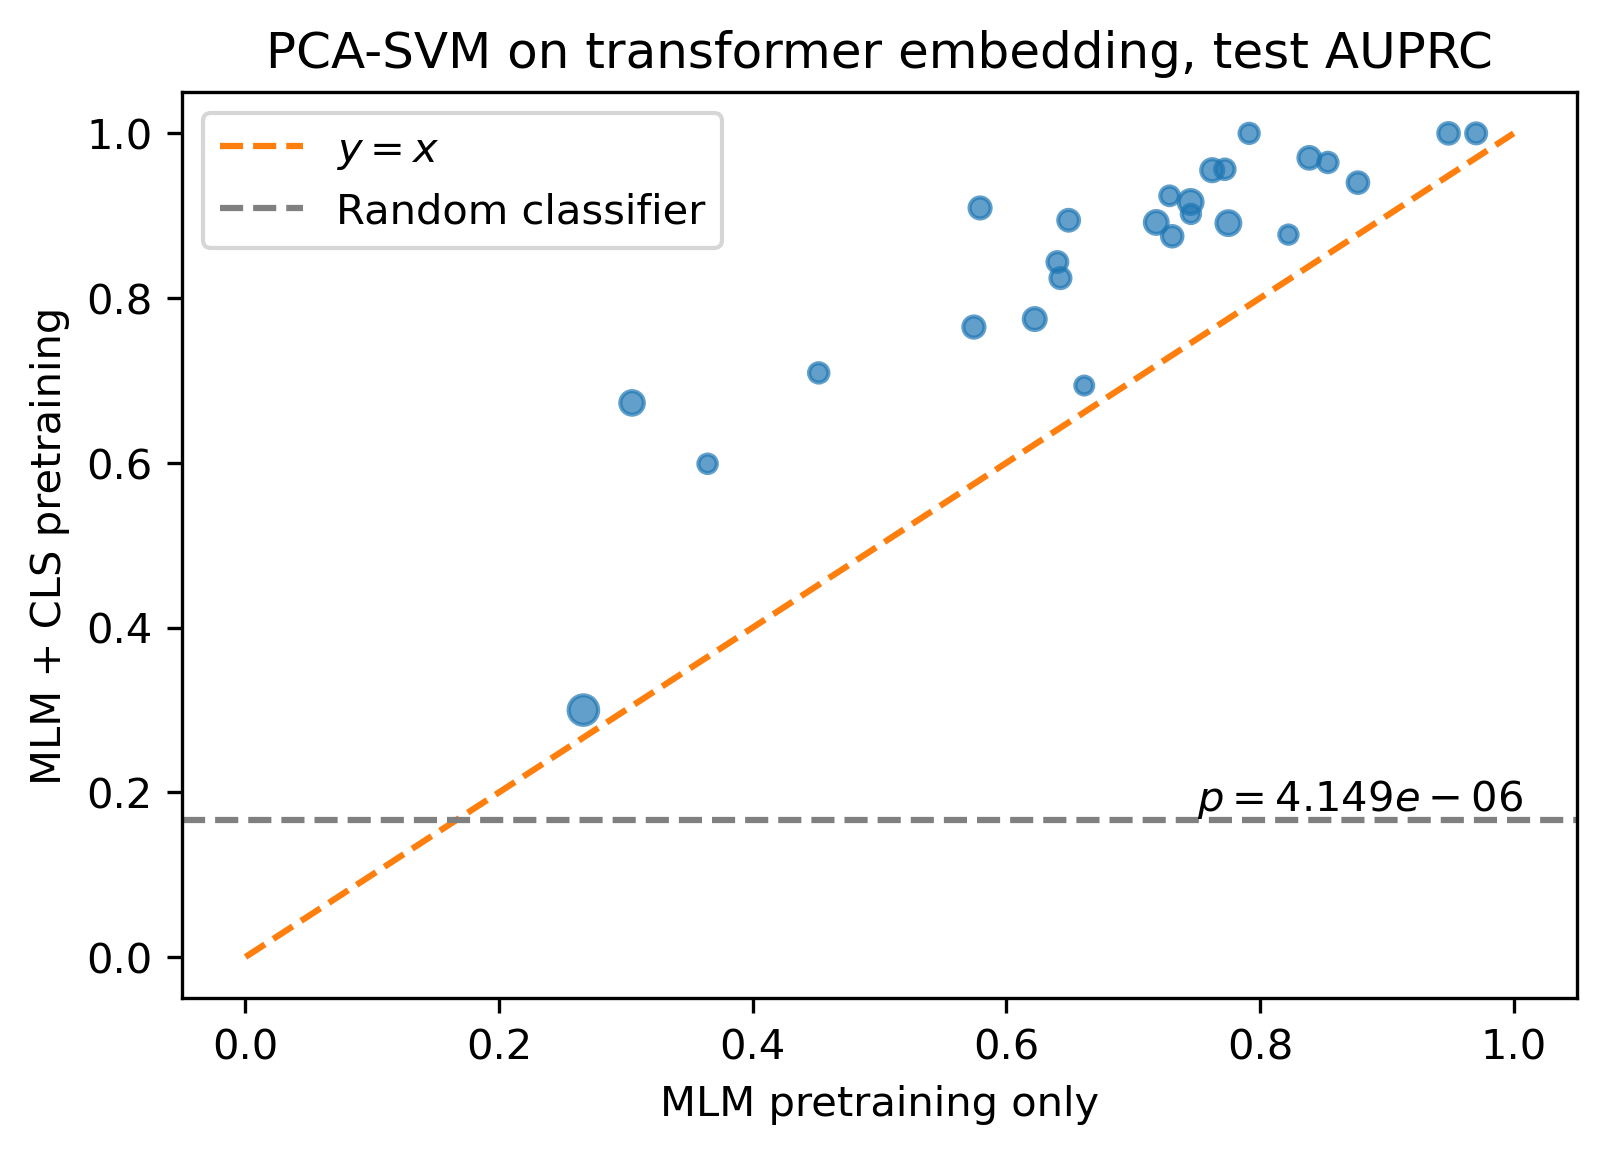

In [45]:
def antigen_cv_plot(xaxis:str, yaxis:str, annot_p:bool = True, data:pd.DataFrame = perf_pairs_df, fname:Optional[str] = None, **kwargs):
    """
    Scatterplot comparing performance of two methods on xaxis and yaxis
    """
    fig, ax = plt.subplots(dpi=300)
    ax.scatter(
        data[xaxis],
        data[yaxis],
        alpha=0.7,
        s=np.log(num_positive_examples) * 6,
    )
    ax.plot([0, 1], [0, 1], linestyle="--", color='tab:orange', label="$y=x$")
    ax.axhline(1/(5+1), linestyle='--', color='grey', label="Random classifier")
    ax.legend()

    stat, pval = stats.wilcoxon(data[xaxis], data[yaxis], alternative='less')
    if annot_p:
        ax.text(0.75, 1/(5+1), f"$p={pval:.4g}$", va='bottom')

    ax.set(**kwargs)
    if fname is not None:
        fig.savefig(fname, bbox_inches='tight')
    return fig

antigen_cv_plot(
    "MLM",
    "MLM + CLS",
    xlabel="MLM pretraining only",
    ylabel="MLM + CLS pretraining",
    title="PCA-SVM on transformer embedding, test AUPRC",
    fname=os.path.join(PLOT_DIR, "mlm_vs_mlmcls.pdf"),
).show()

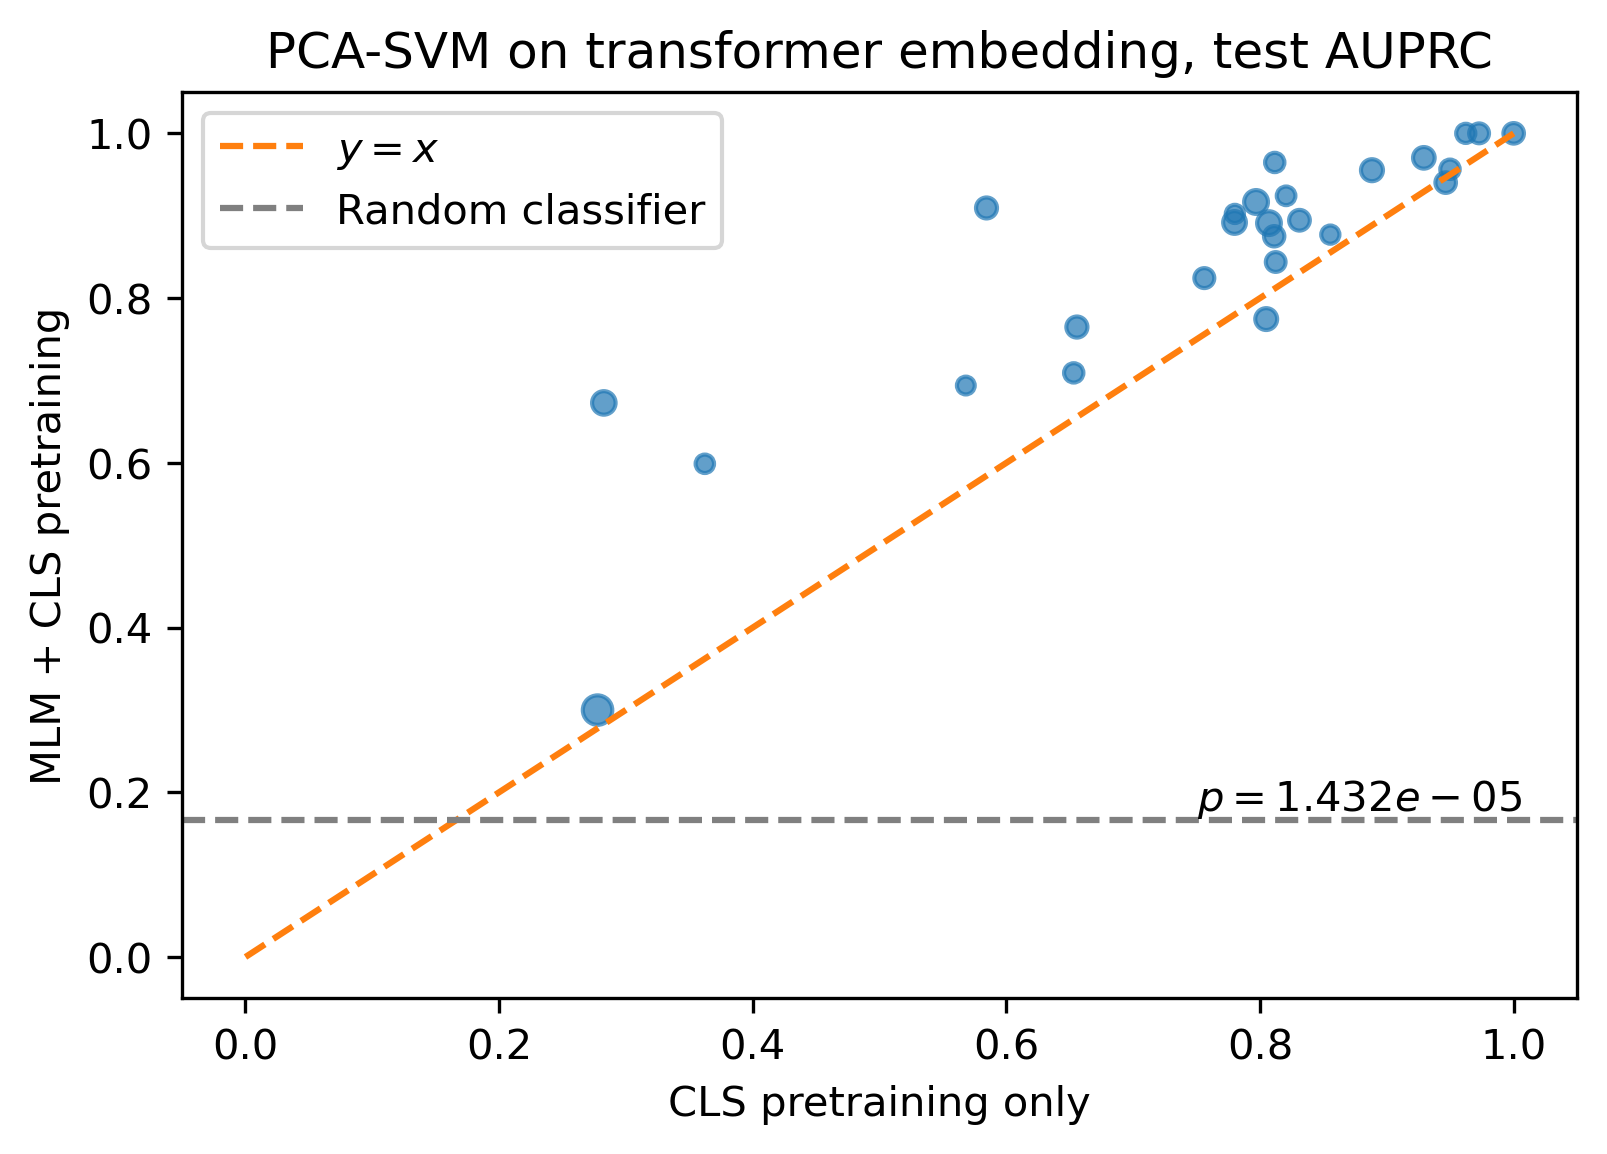

In [46]:
antigen_cv_plot(
    "CLS",
    "MLM + CLS",
    xlabel="CLS pretraining only",
    ylabel="MLM + CLS pretraining",
    title="PCA-SVM on transformer embedding, test AUPRC",
    fname=os.path.join(PLOT_DIR, "cls_vs_mlmcls.pdf"),
).show()

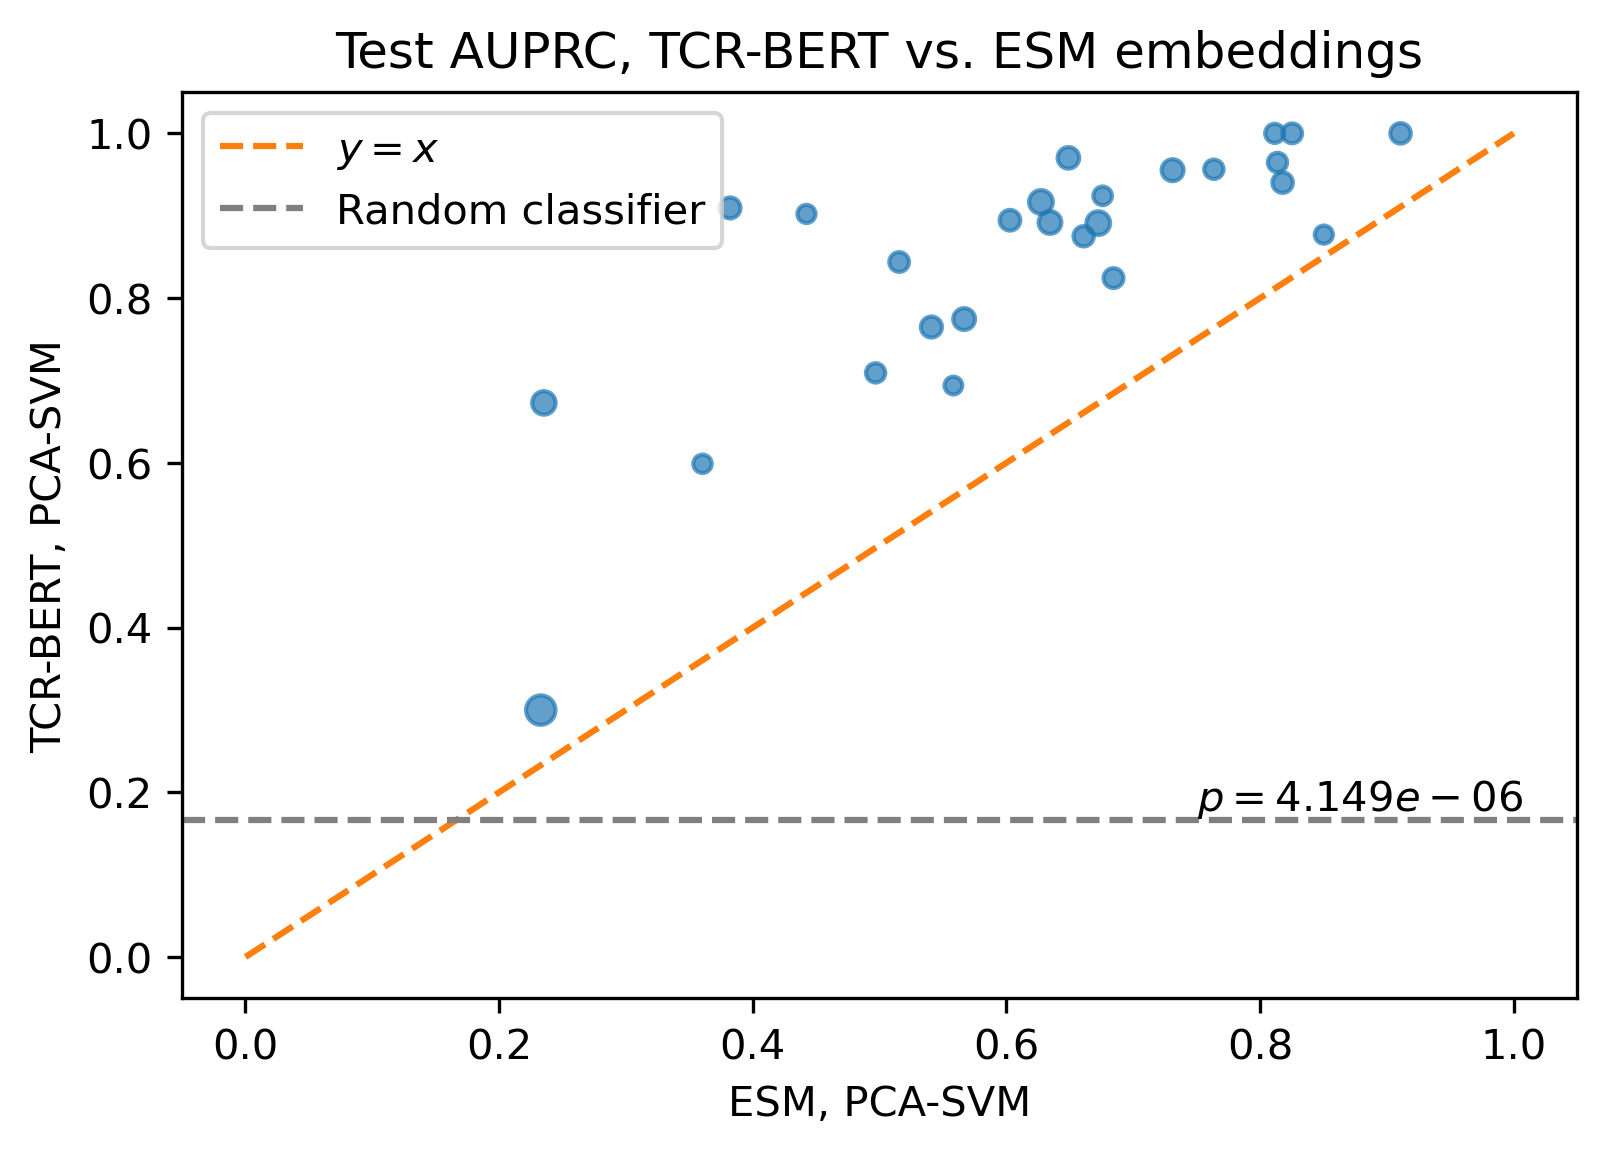

In [48]:
antigen_cv_plot(
    "ESM",
    "MLM + CLS",
    xlabel="ESM, PCA-SVM",
    ylabel="TCR-BERT, PCA-SVM",
    title="Test AUPRC, TCR-BERT vs. ESM embeddings",
    fname=os.path.join(PLOT_DIR, "mlmcls_vs_esm.pdf"),
).show()

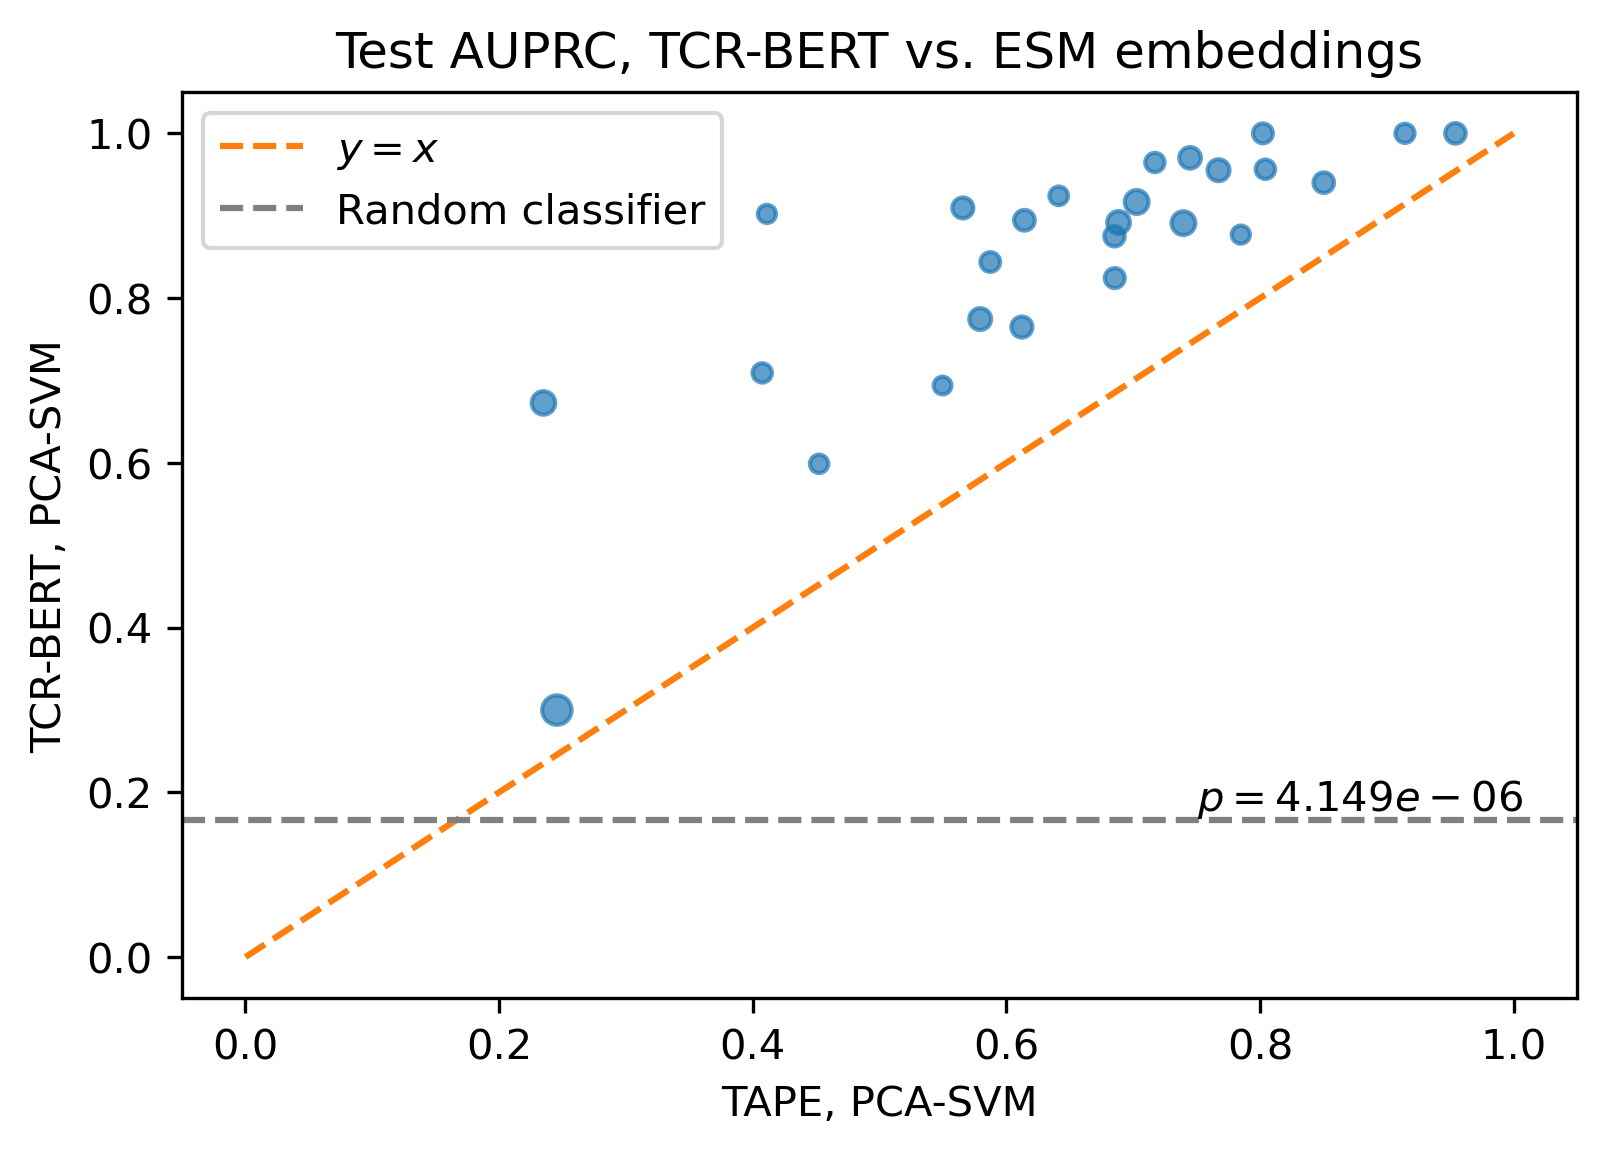

In [49]:
antigen_cv_plot(
    "TAPE",
    "MLM + CLS",
    xlabel="TAPE, PCA-SVM",
    ylabel="TCR-BERT, PCA-SVM",
    title="Test AUPRC, TCR-BERT vs. ESM embeddings",
    fname=os.path.join(PLOT_DIR, "mlmcls_vs_tape.pdf"),
).show()

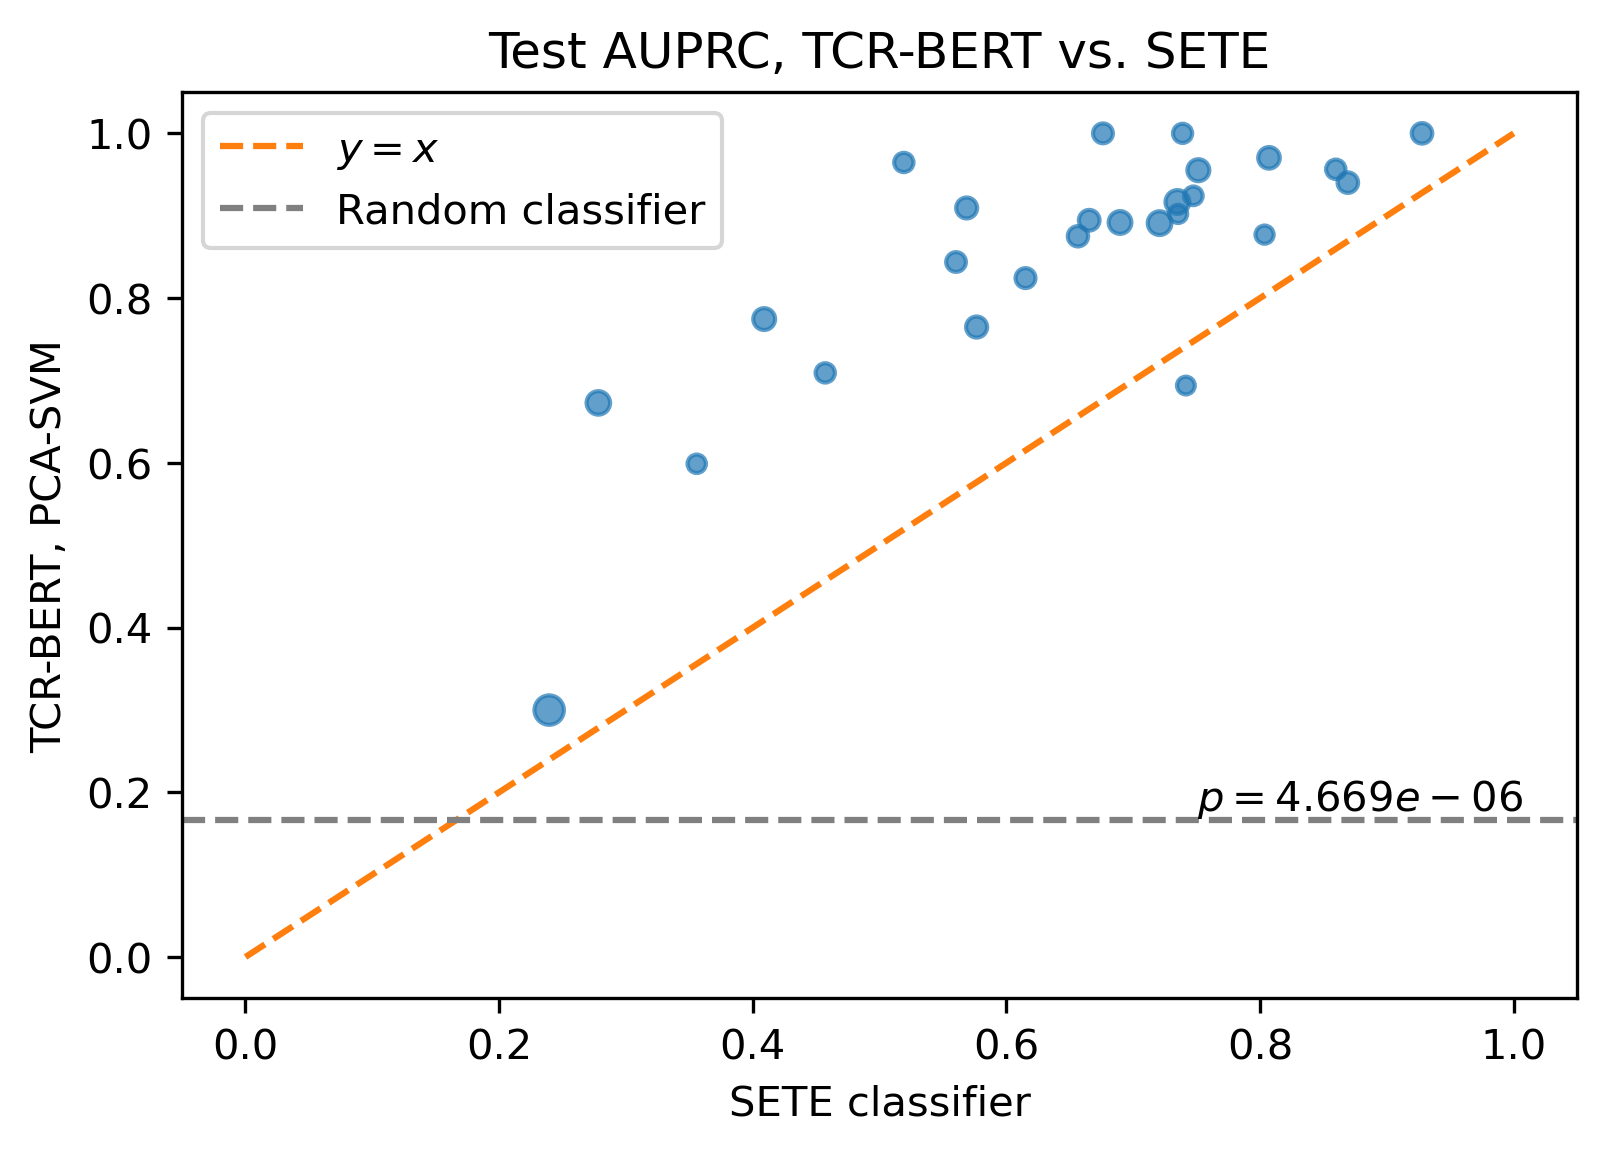

In [50]:
antigen_cv_plot(
    "SETE",
    "MLM + CLS",
    xlabel="SETE classifier",
    ylabel="TCR-BERT, PCA-SVM",
    title="Test AUPRC, TCR-BERT vs. SETE",
    fname=os.path.join(PLOT_DIR, "mlmcls_vs_sete.pdf"),
).show()

## Baseline comparisons

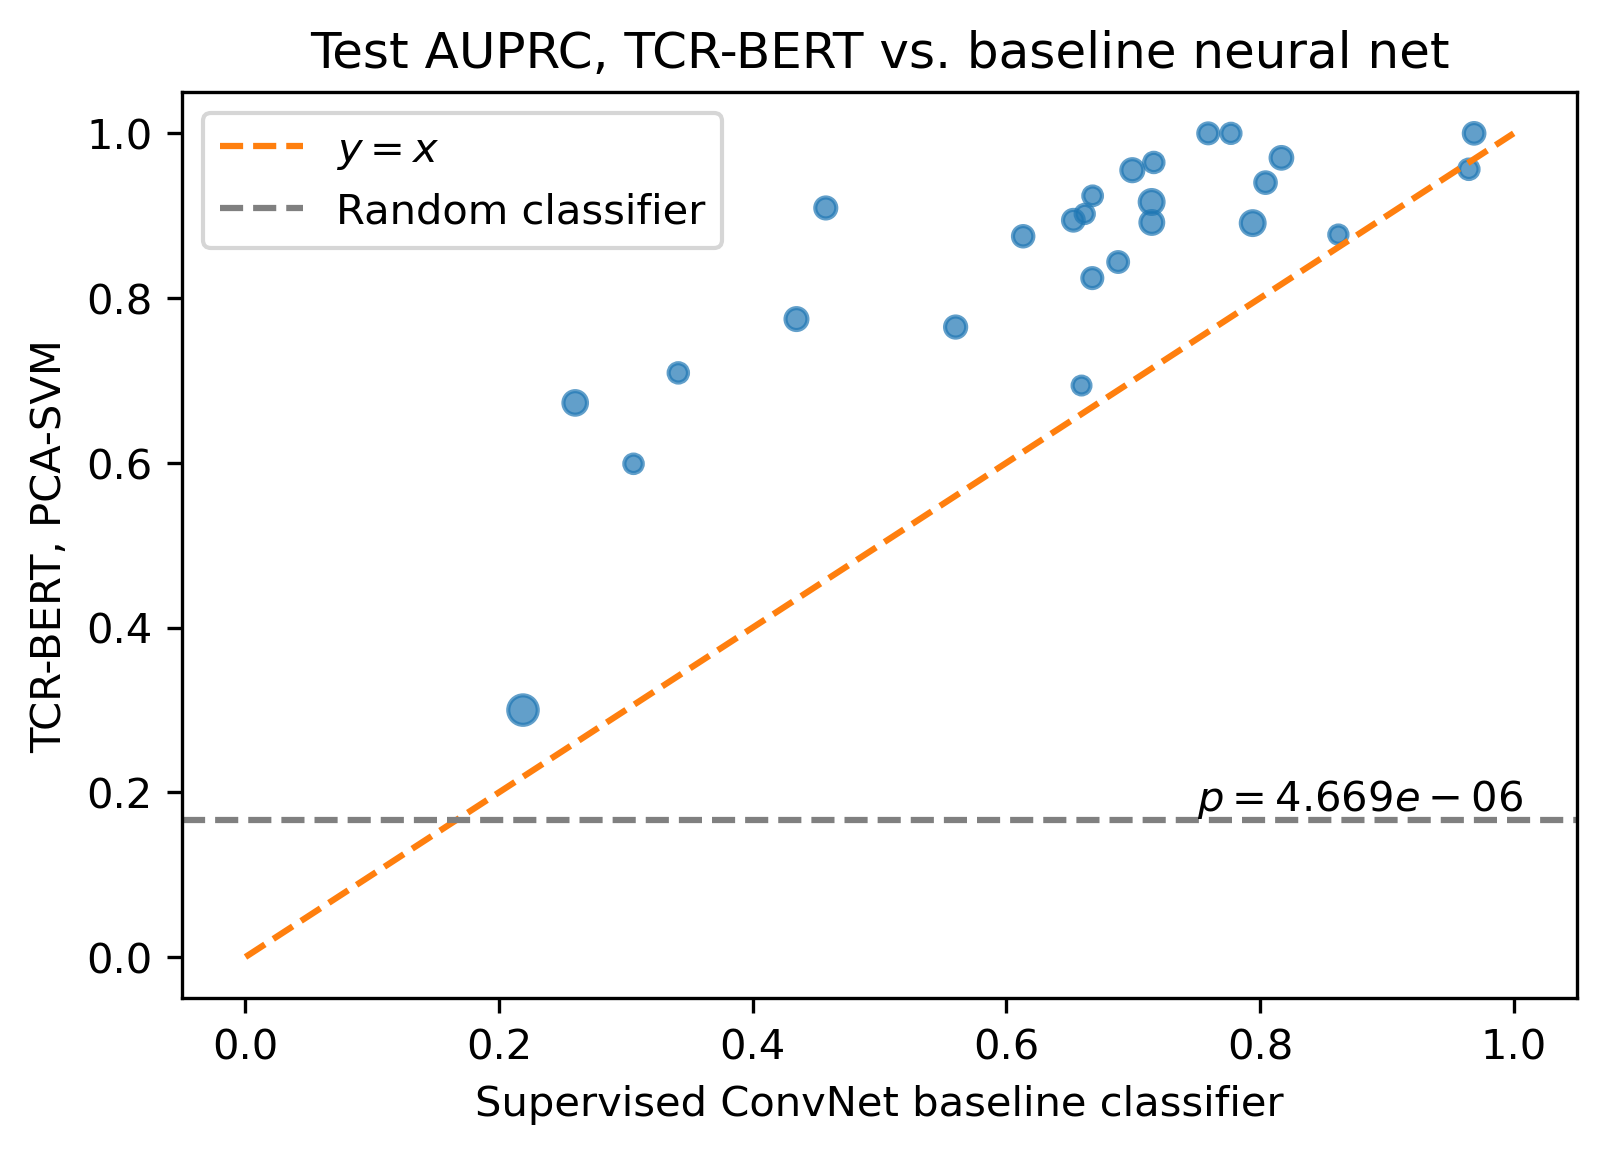

In [51]:
antigen_cv_plot(
    "ConvNet",
    "MLM + CLS",
    xlabel="Supervised ConvNet baseline classifier",
    ylabel="TCR-BERT, PCA-SVM",
    title="Test AUPRC, TCR-BERT vs. baseline neural net",
    fname=os.path.join(PLOT_DIR, "mlmcls_vs_convnet.pdf"),
).show()

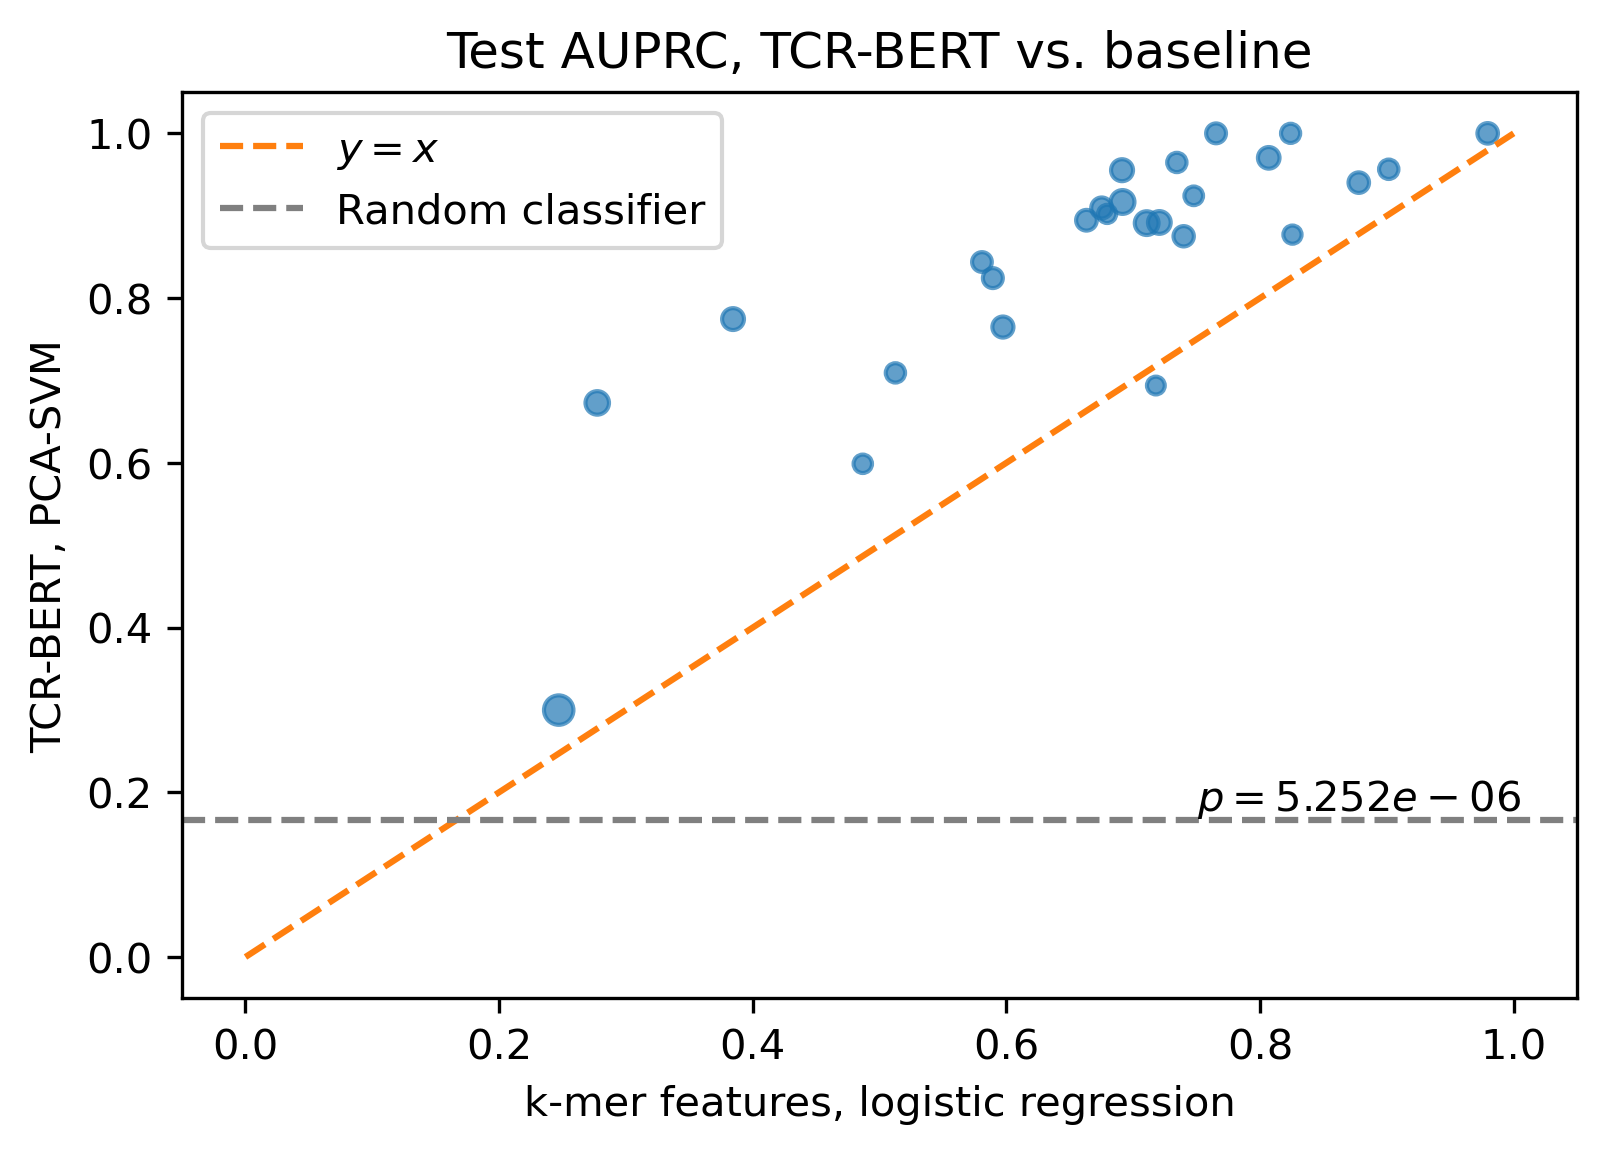

In [52]:
antigen_cv_plot(
    "Logistic on k-mers",
    "MLM + CLS",
    xlabel="k-mer features, logistic regression",
    ylabel="TCR-BERT, PCA-SVM",
    title="Test AUPRC, TCR-BERT vs. baseline",
    fname=os.path.join(PLOT_DIR, "mlmcls_vs_lr.pdf"),
).show()

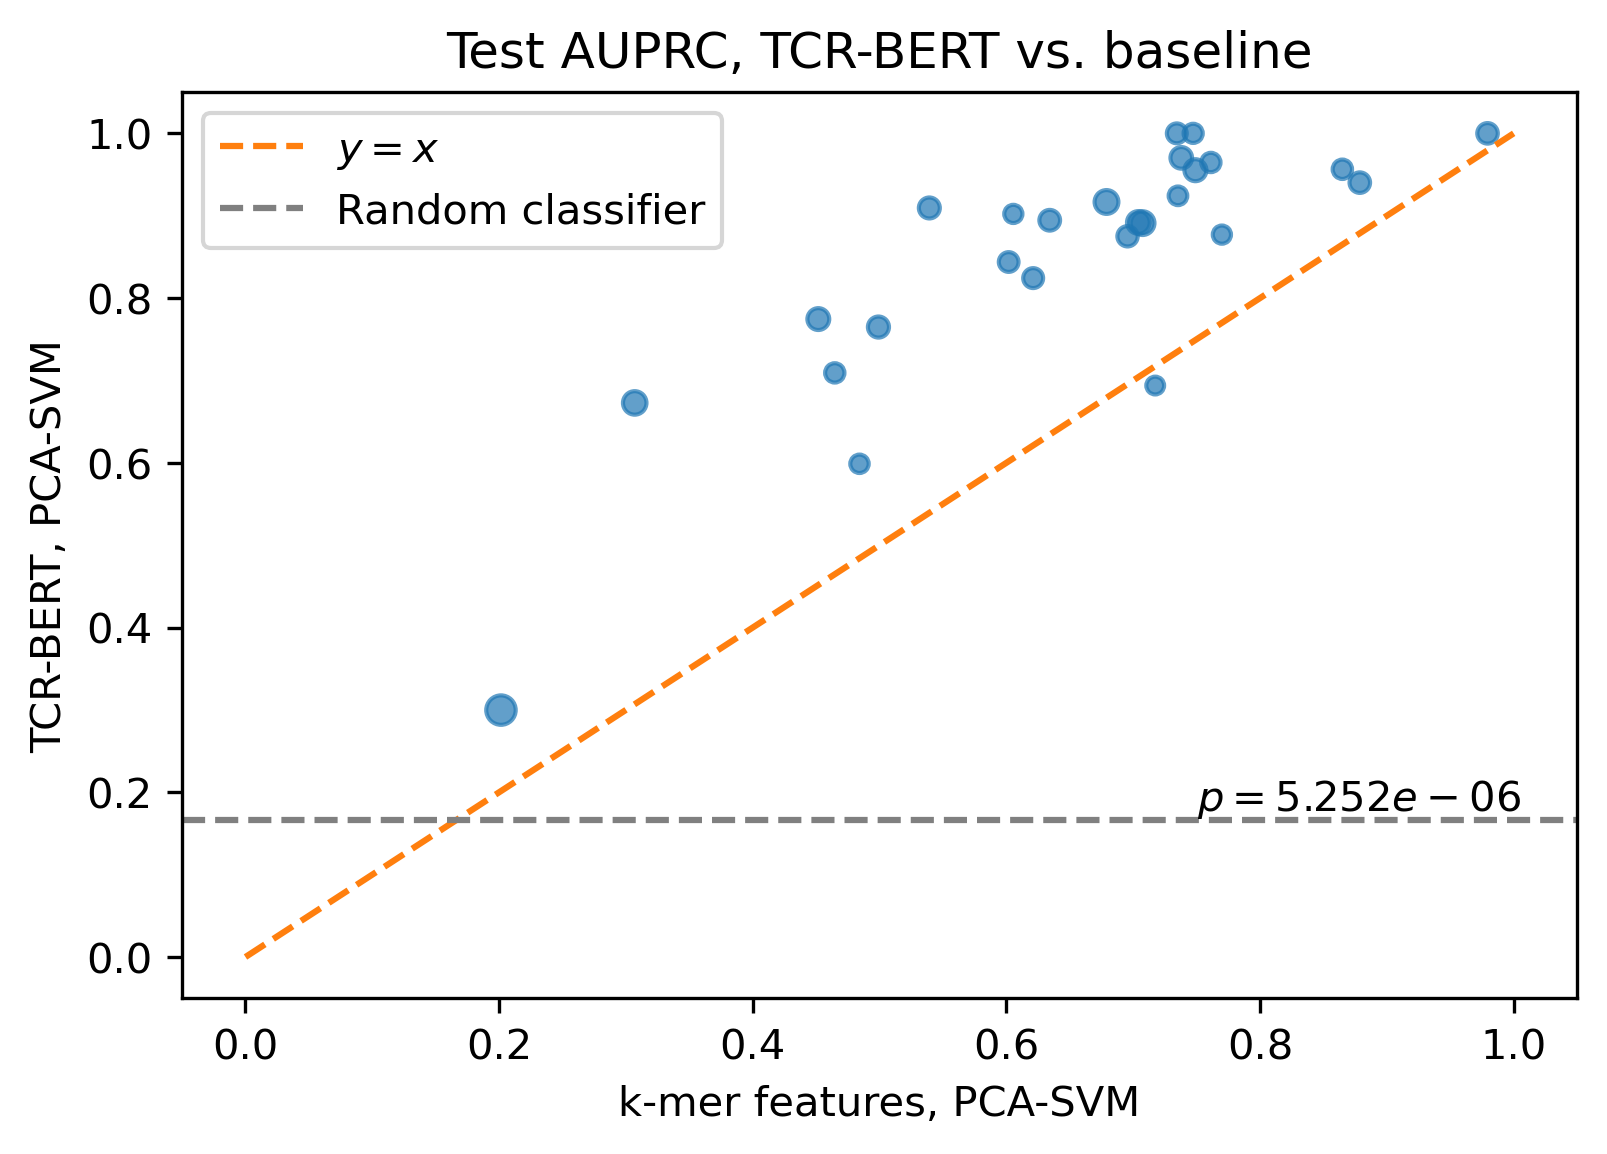

In [53]:
antigen_cv_plot(
    "PCA-SVM on k-mers",
    "MLM + CLS",
    xlabel="k-mer features, PCA-SVM",
    ylabel="TCR-BERT, PCA-SVM",
    title="Test AUPRC, TCR-BERT vs. baseline",
    fname=os.path.join(PLOT_DIR, "mlmcls_vs_pcasvm_kmers.pdf"),
).show()